## Main EMR code

In [3]:
project_path = "../../../../"
utils_path = project_path * "src/utils/"

output_directory = project_path * "data/output/case_EMR/schwarzschild/";

In [4]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
using BSON: @save, @load
gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


In [5]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "test_1_cos/"
model_name = "test_1_cos/"
output_dir = output_directory* "models/" *test_name
solutions_dir = output_dir*"solutions/"
metrics_dir = output_directory*"metrics/"
img_dir = output_dir*"train_img_for_gif/"
list_directories = (output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)


Base.IOError: IOError: mkdir("../../../../data/output/case_EMR/schwarzschild/models/test_1_cos/"; mode=0o777): no such file or directory (ENOENT)

In [6]:
# Define neural network model
NN, NN_params, chain, re = nn_model_case1(model_name);

# --------------------------------------

datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN


χ₀ = Float64(pi); ϕ₀ = 0.0; p=100.0; M=1.0; e=0.5
tspan_train = (0.0f0, 6.0f4)

@info "Train dataset creation"
train_info = get_problem_information_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_train, datasize, dt);

# TEST
χ₀ = Float64(pi); ϕ₀ = 0.0; p=100.0; M=1.0; e=0.5
factor = 50
tspan_test = (tspan_train[1], tspan_train[2])

@info "Test dataset creation"
test_info = get_problem_information_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_test, datasize, dt, factor=factor);

# put data in arrays
@info "Processing datasets"
datasets = (train_info, test_info)
processed_data = process_datasets(datasets)

# --------------------------------------

# zero training image
@info "Generating zero training steps image"

# NN_params = 0 .* NN_params # is it needed¿?
zero_training_solution = Array(solve(remake(train_info["nn_problem"], u0=train_info["u0"], p = NN_params, tspan=train_info["tspan"]), RK4(), saveat = train_info["tsteps"], dt = dt, adaptive=false))
zero_training_waveform = compute_waveform(train_info["dt_data"], zero_training_solution, mass_ratio, train_info["model_params"])[1]

zero_training_plt = train_plot(train_info["tsteps"], train_info["waveform"], zero_training_waveform)

┌ Info: Train dataset creation
└ @ Main /home/rubenbalbastre/Escritorio/TFM/code/01_project/src/processing/schwarzschild/case_EMR/EMR_schwarzschild_train_1.ipynb:16


UndefVarError: UndefVarError: get_problem_information_EMR_scharzschild not defined

In [7]:
# --------------------------------------

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
plot_list = []

callback_EMR(θ, train_loss, train_res_i, test_res, processes_data; show_plots = show_plots, save_plots_gif=save_plots_gif) = begin

    # unpackage training results
    train_loss, train_metric, pred_waveform_real_train = train_res_i
    test_loss, test_metric, pred_waveform_real_test = test_res

    # add losses
    push!(train_losses, train_loss)
    push!(test_losses, test_loss)
    push!(train_metrics, train_metric)
    push!(test_metrics, test_metric)

    # train waveform
    plt1 = train_plot(processes_data["tsteps"][1], processes_data["true_waveform"][1], pred_waveform_real_train)

    # test waveform
    plt2 = test_plot(processes_data["tsteps"][1][end-100:end], processes_data["tsteps"][2][end-100:end], processes_data["true_waveform"][2][end-100:end], pred_waveform_real_test[end-100:end])

    # losses plot
    # plt3 = losses_plot(train_losses, test_losses)


    l = @layout [a; b]
    plt = plot(plt1, plt2, layout=l)
    if save_plots_gif
        push!(plot_list, plt)
    end

    # Tell sciml_train to not halt the optimization. If return true, then optimization stops.
    return false
end


# --------------------------------------

# Train
# NN_params = NN_params + Float64(1e-3)*randn(eltype(NN_params), size(NN_params))
loss_f(p) = loss_function_EMR(p, processed_data=processed_data, train_info=train_info, test_info=test_info)

# optimisers 
# Flux.Optimise.Descent(0.001)
# Flux.Optimise.ADAM(5e-5, (0.9, 0.999)), 
# Flux.Optimise.RADAM(1e-4, (0.9, 0.999)),
# BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()),

println("Start Training")
res = DiffEqFlux.sciml_train(
    loss_f, 
    NN_params,
    BFGS(initial_stepnorm=1e-1, linesearch = LineSearches.BackTracking()), 
    # Flux.Optimise.ADAM(1e-3), 
    cb=callback_EMR, 
    maxiters = 100
);


Start Training


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /home/rubenbalbastre/anaconda3/envs/julia/share/julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


UndefVarError: UndefVarError: processed_data not defined

In [8]:
print(length(plot_list))
plot(plot_list[end])

0

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [0]

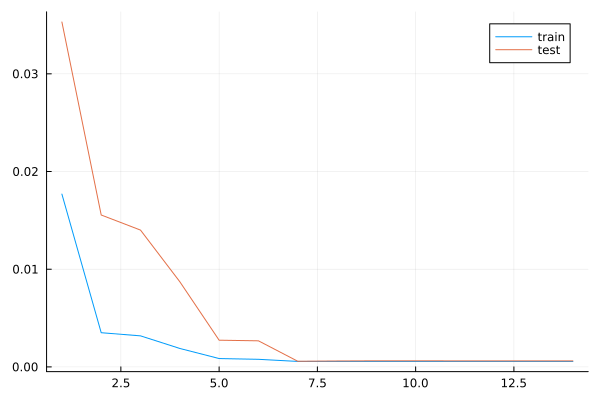

In [6]:
plot(train_losses, label="train")
plot!(test_losses, label="test")

In [6]:

# save flux chain models as bson files. To do so, we must save chain model with its parameters
Flux.loadparams!(chain, Flux.params(re(res.minimizer)))
@save solutions_dir*"model_chiphi.bson" chain

# save losses
losses_df = DataFrame(
    epochs = range(1, length(train_losses)),
    test_name=test_name,
    train_loss = train_losses,
    test_loss = test_losses,
    train_metric = train_metrics,
    test_metric = test_metrics,
    # optimiser="Descent_0.0001"
    # funcion="MAE"
    # pen="l2",
    # conf="g1_1__g2_15"
)

if ! isfile(metrics_dir*"losses.csv")
    CSV.write(metrics_dir*"losses.csv", losses_df)
else
    x = DataFrame(CSV.File(metrics_dir*"losses.csv", types=Dict("test_name" => String31)))
    append!(x, losses_df)
    CSV.write(metrics_dir*"losses.csv", x)
end

if save_data
    savefig(zero_training_plt, img_dir*"0_train_img.pdf")
    savefig(zero_training_plt, img_dir*"0_train_img.png")
    @info "Save train images"
    # save plots
    for (ind, img) in enumerate(plot_list)
        savefig(img, img_dir*string(ind)*"_train_img.pdf")
        savefig(img, img_dir*string(ind)*"_train_img.png")
        if ind == length(plot_list)
            savefig(img, output_dir*"prediction_plot.pdf")
            savefig(img, output_dir*"prediction_plot.png")
        end
    end
end

UndefVarError: UndefVarError: Flux not defined